# testing models from CMIP6 historical runs
This script opens up CMIP6 historical model run files with data on precipitation pr and surface temperature tas and calculates monthly anomalies for each region.  Then tests the models for each region.  


In [1]:
import xarray as xr, matplotlib.pyplot as plt
#import sys 
#sys.path.append('/home/563/kb6999/Models') # use this if the function file is in a different directory to the notebook
from importlib import reload # need to use this if I edit a function file
import os
import numpy as np
import pandas as pd
import cartopy.crs as ccrs # to add in continents and change map projections 
from matplotlib.colors import LinearSegmentedColormap # to change colour bar????
import dask.diagnostics # dask allows you to check how long something is taking to load

In [2]:
# import custom functions
import anomaly_function as func # imports the function
import model_figures as func2

In [3]:
# use this to reload the function file if I make any edits to it
func = reload(func) 
func2 = reload(func2)

In [4]:
!ls /g/data/lp01/CMIP6/CMIP/CAS/CAS-ESM2-0/historical/r1i1p1f1/Amon/pr/gr1.5

v20200302


In [5]:
# store each section of the directory as a string
institution_dir = '/g/data/lp01/CMIP6/CMIP/'
tas_dir = '/historical/r1i1p1f1/Amon/tas/gr1.5/'
pr_dir = '/historical/r1i1p1f1/Amon/pr/gr1.5/'
print(institution_dir, tas_dir, pr_dir)

/g/data/lp01/CMIP6/CMIP/ /historical/r1i1p1f1/Amon/tas/gr1.5/ /historical/r1i1p1f1/Amon/pr/gr1.5/


## Read in model data

In [6]:
models_tas = func.read_models(institution_dir, tas_dir, '1850-01','2015-01')

49 model paths found and loaded into the dictionary "models"
Path for MCM-UA-1-0 does not exist
Model MPI-ESM1-2-HR has different time so is now removed
Model E3SM-1-0 has different time so is now removed
Model EC-Earth3-Veg has different time so is now removed
45 models have been successfully loaded into an xarray


In [7]:
models_pr = func.read_models(institution_dir, pr_dir, '1850-01','2015-01')

48 model paths found and loaded into the dictionary "models"
Path for MCM-UA-1-0 does not exist
47 models have been successfully loaded into an xarray


In [8]:
# make sure the models are the same for both vairables
# delete the height from the models_tas array (if it hasn't been deleted already)
if 'height' in models_tas:
    del models_tas['height']
# delete models that aren't common between variables
models_tas = models_tas.where(models_tas.model.isin(models_pr.model), drop = True)
models_pr = models_pr.where(models_pr.model.isin(models_tas.model), drop = True)
#chekc that the models are the same for both variables and if so print True
models_tas.model.equals(models_pr.model)

True

In [9]:
# combine precipitation and temperature into one dataset
models = xr.Dataset({'tas': models_tas.tas, 'pr': models_pr.pr})
# change the pr units
models['pr'] = models.pr*86400
models

,Array,Chunk
Bytes,10.04 GB,1.38 MB
Shape,"(44, 1980, 120, 240)","(1, 12, 120, 240)"
Count,36929 Tasks,7260 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,20.07 GB,2.76 MB
Shape,"(44, 1980, 120, 240)","(1, 12, 120, 240)"
Count,45181 Tasks,7260 Chunks
Type,float64,numpy.ndarray


In [10]:
# get rid of models with issues
models = models.drop_sel(model=['CIESM'])

In [11]:
# sort models alphabetically and prints final model list
models = models.sortby('model')
print('The following', len(models.model.data), 'models will be used in all subsequent calculations: \n')
print(models.model.data)

The following 43 models will be used in all subsequent calculations: 

['ACCESS-CM2' 'ACCESS-ESM1-5' 'AWI-CM-1-1-MR' 'AWI-ESM-1-1-LR'
 'BCC-CSM2-MR' 'BCC-ESM1' 'CAMS-CSM1-0' 'CAS-ESM2-0' 'CESM2' 'CESM2-FV2'
 'CESM2-WACCM' 'CESM2-WACCM-FV2' 'CMCC-CM2-HR4' 'CMCC-CM2-SR5' 'CanESM5'
 'E3SM-1-1' 'E3SM-1-1-ECA' 'EC-Earth3' 'EC-Earth3-AerChem'
 'EC-Earth3-Veg-LR' 'FGOALS-f3-L' 'FGOALS-g3' 'FIO-ESM-2-0' 'GFDL-CM4'
 'GFDL-ESM4' 'GISS-E2-1-G' 'GISS-E2-1-G-CC' 'GISS-E2-1-H' 'IITM-ESM'
 'INM-CM4-8' 'INM-CM5-0' 'IPSL-CM6A-LR' 'KACE-1-0-G' 'MIROC6'
 'MPI-ESM-1-2-HAM' 'MPI-ESM1-2-LR' 'MRI-ESM2-0' 'NESM3' 'NorCPM1'
 'NorESM2-LM' 'NorESM2-MM' 'SAM0-UNICON' 'TaiESM1']


## select out time around krakatoa eruption
I need to select out the time around each eruption or at least store each eruption in a separate array so that I don't get a "minimum" for one eruption in 1891 and the next in 1991

In [12]:
# select out time around krakatoa eruption
models = models.sel(time = slice('1850-01','1900-01'))
models

,Array,Chunk
Bytes,2.98 GB,1.38 MB
Shape,"(43, 601, 120, 240)","(1, 12, 120, 240)"
Count,53312 Tasks,2193 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,5.95 GB,2.76 MB
Shape,"(43, 601, 120, 240)","(1, 12, 120, 240)"
Count,61564 Tasks,2193 Chunks
Type,float64,numpy.ndarray


In [13]:
# eruption date
e_date = pd.to_datetime(['1883-08','1902-10', '1963-03', '1982-04', '1991-06'])

In [29]:
# save arrays of times relative to each eruption
e_pre5yrs = e_date - 60 * pd.offsets.MonthBegin()
e_pre3mon = e_date - 3 * pd.offsets.MonthBegin()
e_post6mon = e_date + 7 * pd.offsets.MonthBegin()
e_post12mon = e_date + 13 * pd.offsets.MonthBegin()
e_post18mon = e_date + 19 * pd.offsets.MonthBegin()
e_post24mon = e_date + 25 * pd.offsets.MonthBegin()
e_post5yrs = e_date + 61 * pd.offsets.MonthBegin()
e_post10yrs = e_date + 121 * pd.offsets.MonthBegin()

## Select out regions
Right now I have all the models stored in one array so from hereafter I can calculate anomalies etc.  

In [15]:
# area weighting 
models_w = models*np.cos(models_tas.lat*(np.pi/180))

In [16]:
# import land fraction data
landfrac_ds = xr.open_dataset('/home/563/kb6999/Models/landfraction_file_grid1.5.nc')
landmask = landfrac_ds.mean(dim='time')

## Anomalies

In [17]:
# use functions to calculate the monthly anomalies for the globe
mon_anom_Glob = func.monthly_anomaly(models_w, '1850-01', '1881-01')

In [18]:
# select out regions for other anomalies 
mon_anom_SH = mon_anom_Glob.sel(lat=slice(-90,0)) 
mon_anom_NH = mon_anom_Glob.sel(lat=slice(0,90)) 
mon_anom_Aus = mon_anom_Glob.sel(lat=slice(-50,-10), lon=slice(110,160)).where(landmask.data==1, drop=True)
mon_anom_EA = mon_anom_Glob.sel(lat=slice(-50,-10), lon=slice(140,155)).where(landmask.data==1, drop=True)

In [19]:
# use function to add in the mmm to the array, labelled as 'Multi-model mean' in the model dimension
multi_model_Glob = func.add_mmm(mon_anom_Glob)
multi_model_SH = func.add_mmm(mon_anom_SH)
multi_model_Aus = func.add_mmm(mon_anom_Aus)
multi_model_EA = func.add_mmm(mon_anom_EA)

In [20]:
# take the lat lon mean before taking the std 
mean_mon_Glob = multi_model_Glob.mean(dim = ['lat','lon'])
mean_mon_SH = multi_model_SH.mean(dim = ['lat','lon'])
mean_mon_Aus = multi_model_Aus.mean(dim = ['lat','lon'])
mean_mon_EA = multi_model_EA.mean(dim = ['lat','lon'])

In [21]:
# calculate the standard deviation for each model over the time period from 1850-1880
std_Glob = mean_mon_Glob.sel(time = slice('1850-01', '1881-01')).std(dim = ['time'])
std_SH = mean_mon_SH.sel(time = slice('1850-01', '1881-01')).std(dim = ['time'])
std_Aus = mean_mon_Aus.sel(time = slice('1850-01', '1881-01')).std(dim = ['time'])
std_EA = mean_mon_EA.sel(time = slice('1850-01', '1881-01')).std(dim = ['time'])

In [22]:
# calculate the mean for each model over the time period from 1850-1880
time_mean_Glob = mean_mon_Glob.sel(time = slice('1850-01', '1881-01')).mean(dim = ['time'])
time_mean_SH = mean_mon_SH.sel(time = slice('1850-01', '1881-01')).mean(dim = ['time'])
time_mean_Aus = mean_mon_Aus.sel(time = slice('1850-01', '1881-01')).mean(dim = ['time'])
time_mean_EA = mean_mon_EA.sel(time = slice('1850-01', '1881-01')).mean(dim = ['time'])

# Count below threshold for each model
First select only the values below our threshold, then get the count of unmasked values along the time dimension


In [52]:
func = reload(func)

In [27]:
# count the number of times the anomalies are below 1std, 2std, 3std in the 6 months post-eruption
std_count_6mon_Glob = std_count(mean_mon_Glob, time_mean_Glob, std_Glob, e_date[0], e_post6mon[0])
std_count_6mon_SH = std_count(mean_mon_SH, time_mean_SH, std_SH, e_date[0], e_post6mon[0])
std_count_6mon_Aus = std_count(mean_mon_Aus, time_mean_Aus, std_Aus, e_date[0], e_post6mon[0])
std_count_6mon_EA = std_count(mean_mon_EA, time_mean_EA, std_EA, e_date[0], e_post6mon[0])

In [28]:
# count the number of times the anomalies are below 1std, 2std, 3std in the 6-12 months post-eruption
std_count_12mon_Glob = std_count(mean_mon_Glob, time_mean_Glob, std_Glob, e_post6mon[0], e_post12mon[0])
std_count_12mon_SH = std_count(mean_mon_SH, time_mean_SH, std_SH, e_post6mon[0], e_post12mon[0])
std_count_12mon_Aus = std_count(mean_mon_Aus, time_mean_Aus, std_Aus, e_post6mon[0], e_post12mon[0])
std_count_12mon_EA = std_count(mean_mon_EA, time_mean_EA, std_EA, e_post6mon[0], e_post12mon[0])

In [30]:
# count the number of times the anomalies are below 1std, 2std, 3std in the 12-18 months post-eruption
std_count_18mon_Glob = std_count(mean_mon_Glob, time_mean_Glob, std_Glob, e_post12mon[0], e_post18mon[0])
std_count_18mon_SH = std_count(mean_mon_SH, time_mean_SH, std_SH, e_post12mon[0], e_post18mon[0])
std_count_18mon_Aus = std_count(mean_mon_Aus, time_mean_Aus, std_Aus, e_post12mon[0], e_post18mon[0])
std_count_18mon_EA = std_count(mean_mon_EA, time_mean_EA, std_EA, e_post12mon[0], e_post18mon[0])

In [31]:
# count the number of times the anomalies are below 1std, 2std, 3std in the 18-24 months post-eruption
std_count_24mon_Glob = std_count(mean_mon_Glob, time_mean_Glob, std_Glob, e_post18mon[0], e_post24mon[0])
std_count_24mon_SH = std_count(mean_mon_SH, time_mean_SH, std_SH, e_post18mon[0], e_post24mon[0])
std_count_24mon_Aus = std_count(mean_mon_Aus, time_mean_Aus, std_Aus, e_post18mon[0], e_post24mon[0])
std_count_24mon_EA = std_count(mean_mon_EA, time_mean_EA, std_EA, e_post18mon[0], e_post24mon[0])

In [32]:
# count the number of times the anomalies are below 1std, 2std, 3std in the 24-60 months post-eruption
std_count_60mon_Glob = std_count(mean_mon_Glob, time_mean_Glob, std_Glob, e_post24mon[0], e_post5yrs[0])
std_count_60mon_SH = std_count(mean_mon_SH, time_mean_SH, std_SH, e_post24mon[0], e_post5yrs[0])
std_count_60mon_Aus = std_count(mean_mon_Aus, time_mean_Aus, std_Aus, e_post24mon[0], e_post5yrs[0])
std_count_60mon_EA = std_count(mean_mon_EA, time_mean_EA, std_EA, e_post24mon[0], e_post5yrs[0])

# need t ocheck that my std_check function is working properly

In [64]:
# count the number of times the anomalies are below 1std, 2std, 3std at 5 different time periods post-eruption 
std_count_Glob = func.std_check(mean_mon_Glob, time_mean_Glob, std_Glob, e_date[0])
std_count_SH = func.std_check(mean_mon_SH, time_mean_SH, std_SH, e_date[0])
std_count_Aus = func.std_check(mean_mon_Aus, time_mean_Aus, std_Aus, e_date[0])
std_count_EA = func.std_check(mean_mon_EA, time_mean_EA, std_EA, e_date[0])

In [35]:
# define datasets for plotting, ie select out model and vairable so xr can be converted to 1d np array
std = std_Aus.sel(model='Multi-model mean').tas
std2 = 2*std_Aus.sel(model='Multi-model mean').tas
std3 = 3*std_Aus.sel(model='Multi-model mean').tas
mean = time_mean_Aus.sel(model='Multi-model mean').tas
d2 = mean_mon_Aus.sel(time = slice('1883-08', '1888-08')).sel(model='Multi-model mean').tas

## below cell takes too long to compile, more than half an hour

In [38]:
# fig = plt.figure(figsize=(14,8))
# # alpha is the opacity 
# # plt.fill_between(d2.time, d2.where(d2>= std).values, std, interpolate =True, color='crimson', alpha=0.5)
# # plt.fill_between(d2.time, d2.where(d2>= mean).values, mean, interpolate =True, color='crimson', alpha=0.2)
# # plt.fill_between(d2.time, d2.where(d2<= mean).values, mean, interpolate =True, color='royalblue', alpha=0.2)
# plt.fill_between(d2.time, d2.where(d2<= -std).values, -std, interpolate =True, color='royalblue', alpha=0.5)
# # plt.fill_between(d2.time, d2.where(d2<= -std2).values, -std2, interpolate =True, color='royalblue', alpha=0.7)
# # plt.fill_between(d2.time, d2.where(d2<= -std3).values, -std3, interpolate =True, color='royalblue', alpha=0.9)
# anom_dataset.plot(color='k')
# plt.axhline(std, color='k', lw=0.8, ls = ':')
# plt.axhline(mean, color='k', lw=0.8)
# plt.axhline(-std, color='k', lw=0.8, ls = ':')
# plt.axhline(-std2, color='k', lw=0.8, ls = ':')
# plt.axhline(-std3, color='k', lw=0.8, ls = ':')

[########################################] | 100% Completed |  1.2s
[########################################] | 100% Completed |  2.6s
[########################################] | 100% Completed |  2.8s
[########################################] | 100% Completed |  3.5s
[########################################] | 100% Completed |  2.5s
[########################################] | 100% Completed |  2.6s
[########################################] | 100% Completed |  2.5s
[########################################] | 100% Completed |  2.3s
[########################################] | 100% Completed |  2.3s
[########################################] | 100% Completed |  2.7s
[########################################] | 100% Completed |  2.4s
[########################################] | 100% Completed |  2.4s
[########################################] | 100% Completed |  2.4s
[########################################] | 100% Completed |  2.3s
[########################################] | 100

[########################################] | 100% Completed |  2.2s
[########################################] | 100% Completed |  2.3s
[########################################] | 100% Completed |  2.2s
[########################################] | 100% Completed |  2.1s
[########################################] | 100% Completed |  2.3s
[########################################] | 100% Completed |  3.0s
[########################################] | 100% Completed |  2.6s
[########################################] | 100% Completed |  2.5s
[########################################] | 100% Completed |  2.3s
[########################################] | 100% Completed |  2.2s
[########################################] | 100% Completed |  2.9s
[########################################] | 100% Completed |  2.6s
[########################################] | 100% Completed |  2.4s
[########################################] | 100% Completed |  2.4s
[########################################] | 100

KeyboardInterrupt: 

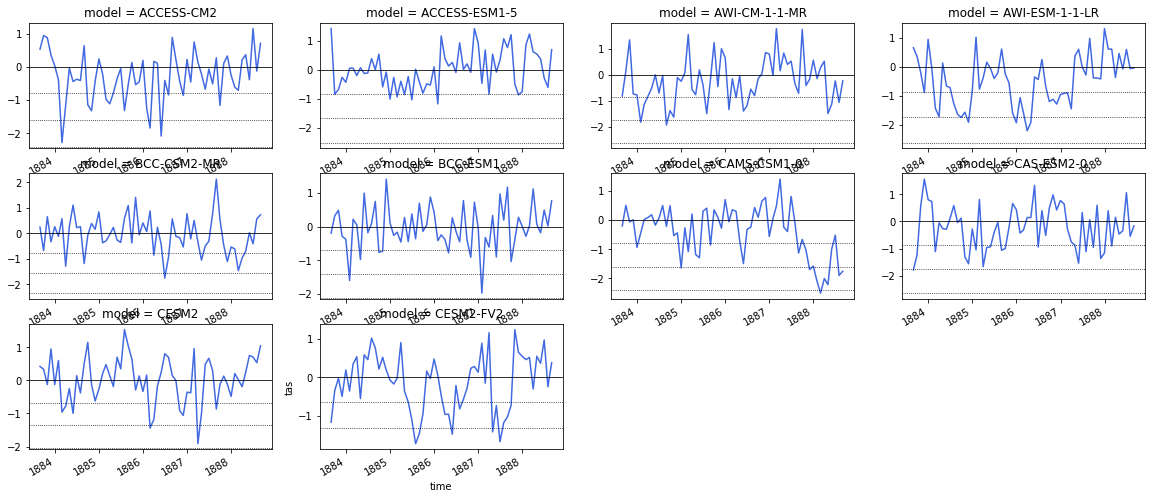

In [148]:
fig = plt.figure(figsize=(20,30))
axs = []

cols = 4
rows = 11

with dask.diagnostics.ProgressBar():
    for i, m in enumerate(K_mean_mon_Aus.model):
        # Add a subplot with a projection
        ax = fig.add_subplot(rows, cols, i+1)

        # Select this model's data and plot it
        K_mean_mon_Aus.sel(model=m).tas.plot(ax=ax, color='royalblue')
        # plot a horizontal line indicating 3 standard deviations
        ax.axhline(0, color='k', lw=0.8)
        ax.axhline((-std_Aus).sel(model=m).tas, color='k', lw=0.8, ls = ':')
        ax.axhline((-std_Aus*2).sel(model=m).tas, color='k', lw=0.8, ls = ':')
        ax.axhline((-std_Aus*3).sel(model=m).tas, color='k', lw=0.8, ls = ':')
        
        # remove x and y axes
        ax.set_xlabel(None)
        ax.set_ylabel(None)

#plt.savefig('statsig_graph_tas.png', dpi=300, bbox_inches='tight')

## need to figure out how to index the model dimension properly

KeyError: 0

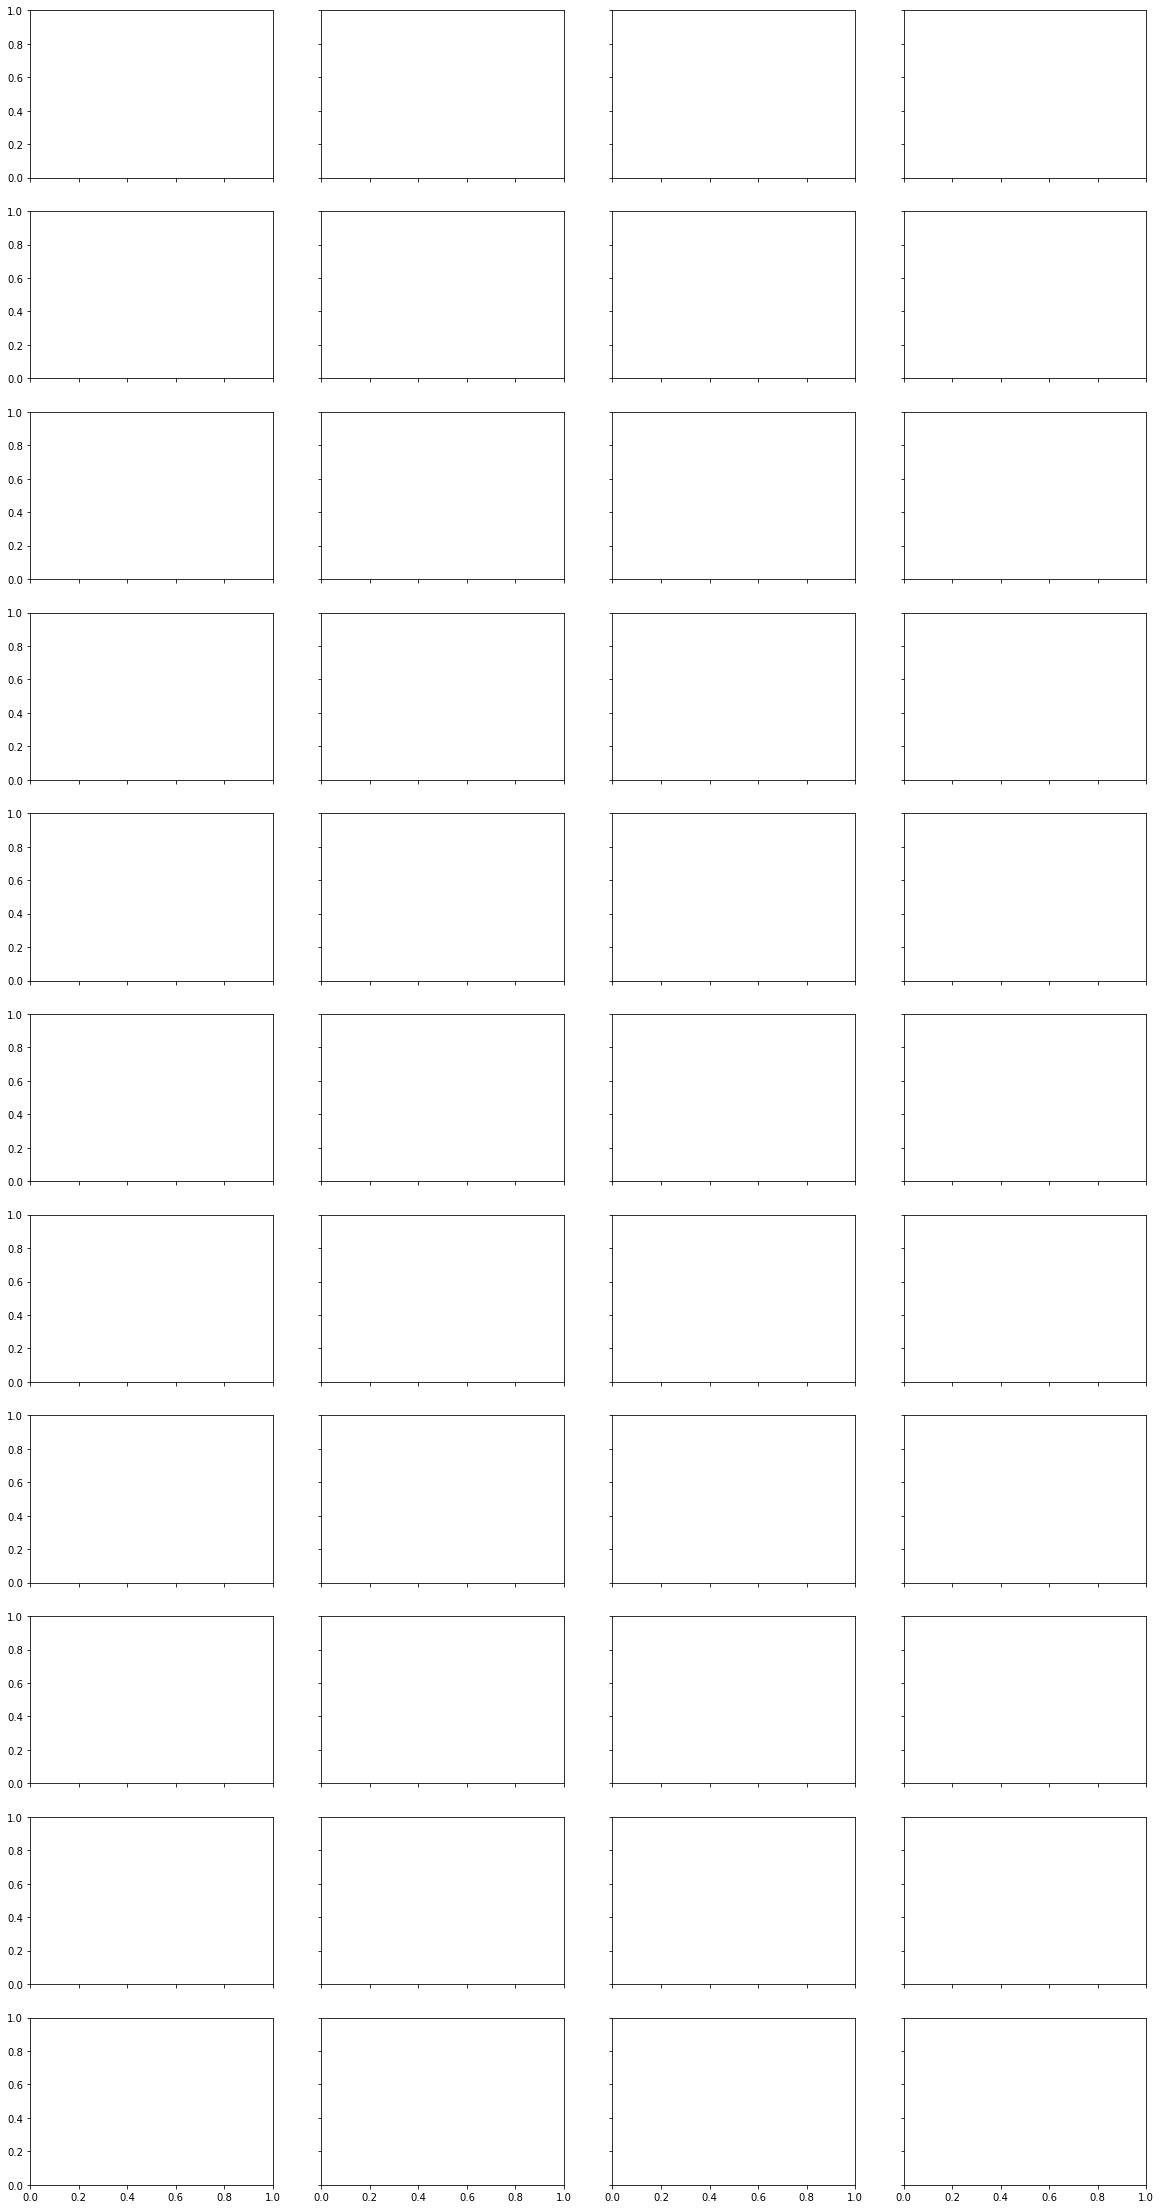

In [150]:
rows = 11
cols=4
fig, axes = plt.subplots(rows, cols, sharex=True, sharey=True, figsize=(20,40))

# make subplots for each region
m=0

for r in range(rows):
    for c in range(cols):
        with dask.diagnostics.ProgressBar():
            K_mean_mon_Aus.model[m].tas.plot(ax = axes[r,c], color = 'royalblue')

        # plot a horizontal line indicating 3 standard deviations
        ax.axhline(0, color='k', lw=0.8)
        ax.axhline((-std_Aus).model[m].tas, color='k', lw=0.8, ls = ':')
        ax.axhline((-std_Aus*2).model[m].tas, color='k', lw=0.8, ls = ':')
        ax.axhline((-std_Aus*3).model[m].tas, color='k', lw=0.8, ls = ':')

        # remove x and y axes
        ax.set_xlabel(None)
        ax.set_ylabel(None)

        m=m+1
                
#plt.savefig('statsig_graph_tas.png', dpi=300, bbox_inches='tight')

condition = mean_mon_Glob < time_mean_Glob - std_Glob

## Minimum values for each model
The same idea, this time using 'min' instead of 'count'

In [55]:
# select out time around krakatoa eruption for graphs and counts, 
K_mean_mon_Glob = mean_mon_Glob.sel(time = slice('1883-08', '1888-08'))
K_mean_mon_SH = mean_mon_SH.sel(time = slice('1883-08', '1888-08'))
K_mean_mon_Aus = mean_mon_Aus.sel(time = slice('1883-08', '1888-08'))
K_mean_mon_EA = mean_mon_EA.sel(time = slice('1883-08', '1888-08'))

In [56]:
# calculate the minimum anomaly (ie the coolest temperature/driest month in the 5 years after krakatoa)
model_min_Glob = K_mean_mon_Glob.min('time')
model_min_SH = K_mean_mon_SH.min('time')
model_min_Aus = K_mean_mon_Aus.min('time')
model_min_EA = K_mean_mon_EA.min('time')

## Date of minimum value for each model¶
Start off by finding the index of the minimum value - argmin.

In [57]:
# calculate the date of the minimum value for each model and store in an array for each region
min_date_Glob = func.min_date(K_mean_mon_Glob, model_min_Glob)
min_date_SH = func.min_date(K_mean_mon_SH, model_min_SH)

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/reductions.py:908: RuntimeWarning: All-NaN slice encountered
  vals = func(x, axis=arg_axis, keepdims=True)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/reductions.py:908: RuntimeWarning: All-NaN slice encountered
  vals = func(x, axis=arg_axis, keepdims=True)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/reductions.py:908: RuntimeWarning: All-NaN slice encountered
  vals = func(x, axis=arg_axis, keepdims=True)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/reductions.py:908: RuntimeWarning: All-NaN slice encountered
  vals = func(x, axis=arg_axis, keepdims=True)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/reductions.py:908: RuntimeWarning: All-NaN slice encountered
  vals = func(x, axis=arg_a

In [58]:
min_date_Aus = func.min_date(K_mean_mon_Aus, model_min_Aus)
min_date_EA = func.min_date(K_mean_mon_EA, model_min_EA)

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/reductions.py:908: RuntimeWarning: All-NaN slice encountered
  vals = func(x, axis=arg_axis, keepdims=True)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/reductions.py:908: RuntimeWarning: All-NaN slice encountered
  vals = func(x, axis=arg_axis, keepdims=True)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/reductions.py:908: RuntimeWarning: All-NaN slice encountered
  vals = func(x, axis=arg_axis,

In [65]:
event_stats_tas_Aus = xr.Dataset({
    'std': std_count_Aus.tas,
    'Min': model_min_Aus.tas,
    'Min Date': min_date_Aus.tas,
})

event_stats_tas_Aus

<xarray.Dataset>
Dimensions:       (count_months: 5, model: 44, std_count: 3)
Coordinates:
  * model         (model) object 'ACCESS-CM2' ... 'Multi-model mean'
  * std_count     (std_count) <U5 '1*std' '2*std' '3*std'
  * count_months  (count_months) <U9 '0-6 mon' '6-12 mon' ... '24-60 mon'
Data variables:
    std           (count_months, std_count, model) int64 dask.array<chunksize=(1, 1, 1), meta=np.ndarray>
    Min           (model) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    Min Date      (model) datetime64[ns] 1884-02-29 1886-01-31 ... 1884-03-31

In [66]:
event_stats_tas_Aus_df = event_stats_tas_Aus.to_dataframe()
event_stats_tas_Aus_df = event_stats_tas_Aus_df.round(decimals=2)

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [88]:
event_stats_tas_Aus_df

std   Min   Min Date
count_months model            std_count                      
0-6 mon      ACCESS-CM2       1*std        1 -2.28 1884-02-29
                              2*std        1 -2.28 1884-02-29
                              3*std        0 -2.28 1884-02-29
             ACCESS-ESM1-5    1*std        1 -1.17 1886-01-31
                              2*std        0 -1.17 1886-01-31
...                                      ...   ...        ...
24-60 mon    TaiESM1          2*std        1 -1.92 1887-08-31
                              3*std        0 -1.92 1887-08-31
             Multi-model mean 1*std       25 -0.54 1884-03-31
                              2*std        8 -0.54 1884-03-31
                              3*std        1 -0.54 1884-03-31

[660 rows x 3 columns]

In [113]:
result_month = event_stats_tas_Aus_df.pivot_table(index='model', columns=['count_months', 'std_count'])

import seaborn as sns

cm = sns.light_palette("blue", as_cmap=True)

s = result_month.style.background_gradient(cmap=cm)
s

# def background(std):

#     result_month = std > 0
#     return ['background-color: royalblue' if v 
#         else '' for v in result_month]

# result_month.style.apply(background)

In [105]:
# The text for the combined result
# ('model','std_count','count_months', 'Min', 'Min Date')
result_month = event_stats_tas_Aus_df.pivot_table(index='model', columns=['count_months', 'std_count'])
type_background = {
#     3 : 'background-color: royalblue',
#     2 : 'background-color: dodgerblue',
    0 : 'background-color: lightblue',
}
background = result_month.applymap(lambda x: type_background[x])
table = result_month.style.apply(lambda x: background, axis=None)
table

KeyError: -2.28

In [133]:
stats_tas_Glob = func.combine_stats(model_2std_count_Glob.tas, model_3std_count_Glob.tas, model_min_Glob.tas, min_date_Glob.tas)
stats_tas_SH = func.combine_stats(model_2std_count_SH.tas, model_3std_count_SH.tas, model_min_SH.tas, min_date_SH.tas)
stats_tas_Aus = func.combine_stats(model_2std_count_Aus.tas, model_3std_count_Aus.tas, model_min_Aus.tas, min_date_Aus.tas)
stats_tas_EA = func.combine_stats(model_2std_count_EA.tas, model_3std_count_EA.tas, model_min_EA.tas, min_date_EA.tas)

In [135]:
stats_pr_Glob = func.combine_stats(model_2std_count_Glob.pr, model_3std_count_Glob.pr, model_min_Glob.pr, min_date_Glob.pr)
stats_pr_SH = func.combine_stats(model_2std_count_SH.pr, model_3std_count_SH.pr, model_min_SH.pr, min_date_SH.pr)
stats_pr_Aus = func.combine_stats(model_2std_count_Aus.pr, model_3std_count_Aus.pr, model_min_Aus.pr, min_date_Aus.pr)
stats_pr_EA = func.combine_stats(model_2std_count_EA.pr, model_3std_count_EA.pr, model_min_EA.pr, min_date_EA.pr)

In [72]:
# combine into one dataset for each region and variable 
event_stats_tas_Aus = xr.Dataset({
    'Count 2*std': model_2std_count_Aus.tas,
    'Count 3*std': model_3std_count_Aus.tas,
    'Min': model_min_Aus.tas,
    'Min Date': min_date_Aus.tas,
})

event_stats_tas_Aus

<xarray.Dataset>
Dimensions:      (model: 44)
Coordinates:
  * model        (model) object 'ACCESS-CM2' ... 'Multi-model mean'
Data variables:
    Count 2*std  (model) int64 dask.array<chunksize=(1,), meta=np.ndarray>
    Count 3*std  (model) int64 dask.array<chunksize=(1,), meta=np.ndarray>
    Min          (model) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    Min Date     (model) datetime64[ns] 1884-02-29 1886-01-31 ... 1884-03-31

In [77]:
event_stats_tas_Aus_df = event_stats_tas_Aus.to_dataframe()
event_stats_tas_Aus_df.round(decimals=2)

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


,Count 2*std,Count 3*std,Min,Min Date
model,,,,
ACCESS-CM2,3,0,-2.28,1884-02-29
ACCESS-ESM1-5,0,0,-1.17,1886-01-31
AWI-CM-1-1-MR,2,1,-1.93,1884-08-31
AWI-ESM-1-1-LR,5,0,-2.21,1886-03-31
BCC-CSM2-MR,1,0,-1.76,1886-06-30
BCC-ESM1,2,0,-1.97,1887-01-31
CAMS-CSM1-0,8,2,-2.51,1888-02-29
CAS-ESM2-0,1,4,-1.78,1883-08-31
CESM2,2,0,-1.91,1887-03-31


## figure out how to convert datafram to latex table 

## Climtas event detection
The climtas library has some functions for event detection - it will find runs where a condition is true for multiple times, then let you run a function to calculate statistics for each event

In [ ]:
K_mean_mon_Glob < K_time_mean_Glob - 2*std_Glob

In [ ]:
import climtas

events = climtas.event.find_events(mean_mon_Glob.pr < time_mean_Glob.pr - std_Glob.pr, min_duration=2)
events

In [ ]:
coords = climtas.event.event_coords(mean_mon_Glob.pr, events)

def stat_func(event_data):
    return {'min': event_data.min().values,
            'min_date': event_data.time[event_data.argmin()].values}
    
minimum = climtas.event.map_events(da, events, stat_func)

coords.join(minimum)